# Extending the Bonzanni 2013 model

Bonzanni et al. built an 11-gene Boolean network that recapitulates heterogeneity within haematopoietic stem and progenitor cells (HSPCs) and predicts the erythroid/megakaryocyte branch.  
  
However, it lacks cytokine-receptor signalling that could influence the activation of lineage specifying TFs (PMID: 35030198). Studies showed that Boolean networks lacking cytokine receptors systematically underestimate the reachability of PU.1 (SPI1)-high myeloid states and fail to track leukemogenic trajectories (PMID: 28584084).  
   
CEBPA is maximally expressed in CMP/GMP and directly binds PU.1 enhancer to activate transcription and reinforce granulopoiesis (PMID: 29847803). Moreover, biallelic or dominant-negative CEBPA mutations account for ~10 % of adult AML and alter PU.1 expression programmes (PMID: 40221437). Entending the model with CEBPA-PU.1 regulation thus provides a mechanistic entry point for modelling both normal myelopoiesis and CEBPA-mutant AML.


In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

sys.path.append('./src')
import BNMPy
import Optimizer

network_file = "../input_files/Bonzanni2013.txt"
network = BNMPy.load_network_from_file(network_file)
BNMPy.vis_network(network, output_html="Bonzanni2013.html", interactive=True)

No initial state provided, using a random initial state
Network loaded successfully. There are 11 genes in the network.
Network visualization saved to Bonzanni2013.html


In [11]:
calc = BNMPy.SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(n_runs=100,n_steps=10000)

Found 2 fixed points and 2 cyclic attractors
--------------------------------
Fixed points: 
Fixed point 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fixed point 2: [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
--------------------------------
Cyclic attractors: 
Cyclic attractor 1: [[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]]
Cyclic attractor 2: [[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]]
--------------------------------
Node order: dict_keys(['SPI1', 'GATA1', 'GATA2', 'TAL1', 'ZFPM1', 'FLI1', 'ERG', 'CBFA2T3', 'RUNX1', 'SMAD6', 'HHEX'])


## Extend with CEBPA

In [55]:
# get the knowledge graph-derived network
genes = ['GATA1', 'SPI1', 'ERG', 'FLI1', 'TAL1', 'SMAD6', 'ZFPM1', 'RUNX1', 'HHEX', 'GATA2' ,'CEBPA']
KG_string,relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')
KG = BNMPy.load_network_from_string(KG_string)
print(KG_string)

number of genes found: 11
[2623, 6688, 2078, 2313, 6886, 4091, 161882, 861, 3087, 2624, 1050]
No initial state provided, using a random initial state
Network loaded successfully. There are 12 genes in the network.
CEBPA = (!SMAD3 & !GATA1) & CEBPA
ERG = (TAL1 | ERG | FLI1)
FLI1 = (SPI1 | GATA1)
GATA1 = !SPI1 & (GATA1 | FLI1 | GATA2)
GATA2 = (!SPI1 & !GATA1 & !ZFPM1) & GATA2
HHEX = RUNX1
RUNX1 = GATA1
SMAD3 = !SMAD6 & SMAD3
SMAD6 = SMAD6
SPI1 = (!GATA1 & !GATA2) & (SPI1 | CEBPA | RUNX1)
TAL1 = !SPI1 & GATA1
ZFPM1 = GATA1


In [3]:
# Extend the network using PBN
extended_network_string = BNMPy.extend_networks(network, KG, ['CEBPA'], prob=0.5)
print('\n')
print(extended_network_string)

Nodes affected: ['CEBPA', 'SMAD3', 'SPI1']

Gene: CEBPA
  Not present in original network
  Added rule: CEBPA & !GATA1 & !SMAD3, 1

Gene: SMAD3
  Not present in original network
  Added rule: SMAD3 & !SMAD6, 1

Gene: SPI1
  Original rule: ( FLI1 | RUNX1 | SPI1 ) & ( !GATA1 | !SPI1 )
  Added rule: !GATA1 & !GATA2 & ( CEBPA | RUNX1 | SPI1 ), 0.5


CBFA2T3 = GATA2 & TAL1, 1.0
CEBPA = CEBPA & !GATA1 & !SMAD3, 1.0
ERG = ( !CBFA2T3 | !TAL1 ) & ( ERG | FLI1 | GATA2 | RUNX1 ), 1.0
FLI1 = !GATA1 & ( ERG | FLI1 | GATA2 ), 1.0
GATA1 = GATA1 & !SPI1 & TAL1, 1.0
GATA2 = ( ERG | FLI1 | ( GATA2 & TAL1 ) ) & ( !GATA1 | !ZFPM1 ) & ( !GATA2 | !HHEX ), 1.0
HHEX = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0
RUNX1 = ( ERG | FLI1 | RUNX1 | SPI1 | ( GATA2 & TAL1 ) ) & ( !RUNX1 | !SMAD6 ), 1.0
SMAD3 = SMAD3 & !SMAD6, 1.0
SMAD6 = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0
SPI1 = !GATA1 & !GATA2 & ( CEBPA | RUNX1 | SPI1 ), 0.5
SPI1 = ( FLI1 | RUNX1 | SPI1 ) & ( !GATA1 | !SPI1 ), 0.5
TAL1 = ERG | FLI1 | ( GATA1 & TAL1 ) | ( GATA

In [4]:
pbn = BNMPy.load_pbn_from_string(extended_network_string)
BNMPy.vis_extension(network,pbn, output_html="Bonzanni2013_extended_CEBPA.html", interactive=True)

No initial state provided, using a random initial state
PBN loaded successfully. There are 13 genes in the network.
Extension comparison:
  Original nodes: 11
  Extended nodes: 13
  New nodes: 2 - ['CEBPA', 'SMAD3']
  Original edges: 42
  Extended edges: 46
  New edges: 5
Extension visualization saved to Bonzanni2013_extended_CEBPA.html


## Optimize the network

We then need to find the optimal probability of the new added edge. Three datasets are used for training: Ramos2006, Chambers2007, Lara-Astiaso2014.
- Ramos2006: LT-HSC single-cell micro-arrays, PMID: 17009876
- Chambers2007: haematopoietic fingerprints, a collection of expression profiling data for HSPCs + 9 differentiated lineages, PMID: 18371395
- Lara-Astiaso2014: RNA-seq during hematopoiesis across 16 different cell types, PMID: 25103404

Expression data of PU.1 (SPI1) from HSCs, erythroids and myeloid push through CEBPA are obtained from the three datasets respectively and normalized to the range of 0-1.

In [5]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 20,
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1, # disable early stopping
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'p_mir': 0.05,
                'freeze_constant': True
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.01, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}
data = '../input_files/Bonzanni2013_data_CEBPA.csv'

In [6]:
optimizer = Optimizer.ParameterOptimizer(
    pbn,
    data, 
    config=config, 
    nodes_to_optimize=["SPI1"],  # optimize the affected nodes
    verbose=False)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-04 21:32:11,184 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...




pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0123
2025-08-04 22:09:23,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.012300074659607939, best pos: [0.76500249 0.18788683]
2025-08-04 22:09:23,240 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 2/2
Running PSO optimization...




pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=0.0116/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0116
2025-08-04 22:46:06,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.011589461885299635, best pos: [0.56599872 0.16136775]



--- Optimization finished. Best MSE found: 0.011589 ---

--- Optimized PBN Rules ---
CBFA2T3 = GATA2 & TAL1, 1.0000
CEBPA = CEBPA & !GATA1 & !SMAD3, 1.0000
ERG = ( !CBFA2T3 | !TAL1 ) & ( ERG | FLI1 | GATA2 | RUNX1 ), 1.0000
FLI1 = !GATA1 & ( ERG | FLI1 | GATA2 ), 1.0000
GATA1 = GATA1 & !SPI1 & TAL1, 1.0000
GATA2 = ( ERG | FLI1 | ( GATA2 & TAL1 ) ) & ( !GATA1 | !ZFPM1 ) & ( !GATA2 | !HHEX ), 1.0000
HHEX = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
RUNX1 = ( ERG | FLI1 | RUNX1 | SPI1 | ( GATA2 & TAL1 ) ) & ( !RUNX1 | !SMAD6 ), 1.0000
SMAD3 = SMAD3 & !SMAD6, 1.0000
SMAD6 = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
SPI1 = !GATA1 & !GATA2 & ( CEBPA | RUNX1 | SPI1 ), 0.7781
SPI1 = ( FLI1 | RUNX1 | SPI1 ) & ( !GATA1 | !SPI1 ), 0.2219
TAL1 = ERG | FLI1 | ( GATA1 & TAL1 ) | ( GATA2 & TAL1 ), 1.0000
ZFPM1 = GATA2 & TAL1, 1.0000
---------------------------



Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
Simulation completed: 5 data points


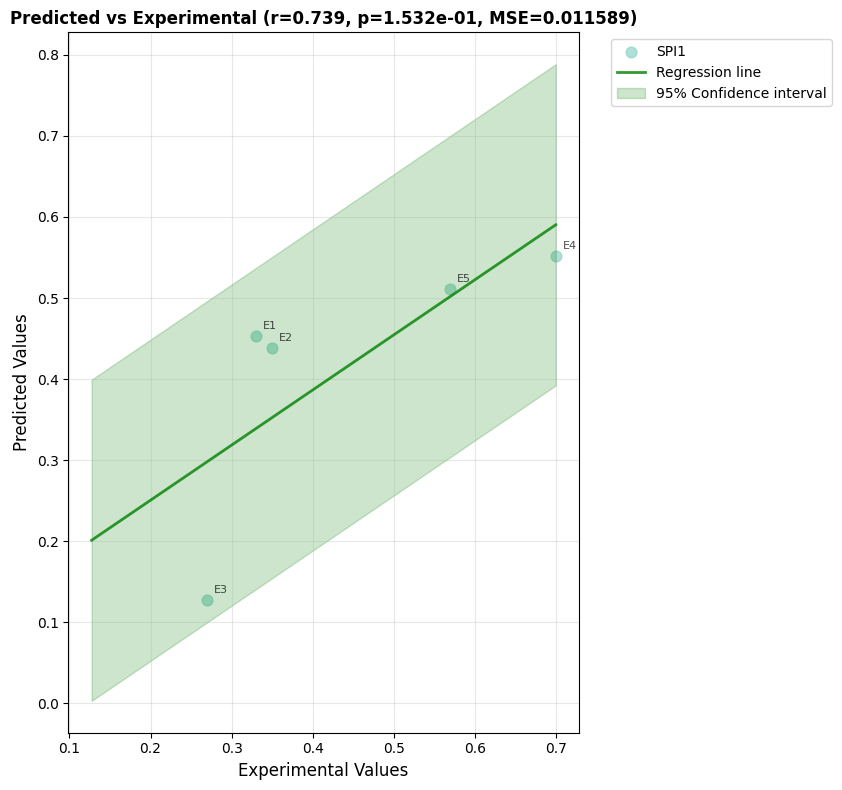

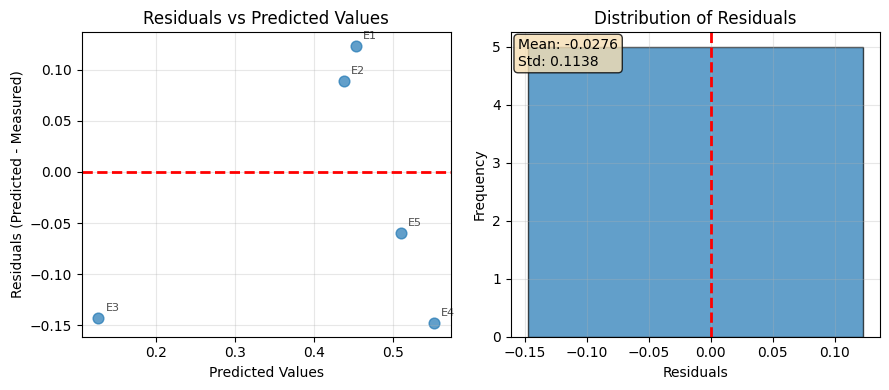

OPTIMIZATION RESULT EVALUATION REPORT

OVERALL PERFORMANCE:
--------------------
Pearson Correlation: 0.7395
P-value: 1.532166e-01
R-squared: 0.4860
Mean Squared Error: 0.013726
Root Mean Squared Error: 0.117158
Mean Absolute Error: 0.112234
Number of data points: 5

OPTIMIZATION DETAILS:
--------------------
Final MSE: 0.011589
Success: False
Iterations: 100
Function evaluations: 2000

PER-NODE PERFORMANCE:
--------------------
SPI1:
  Correlation: 0.7395 (p = 1.5322e-01)
  MSE: 0.013726
  MAE: 0.112234
  Data points: 5



In [9]:
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    save=False,
    detailed=True
)

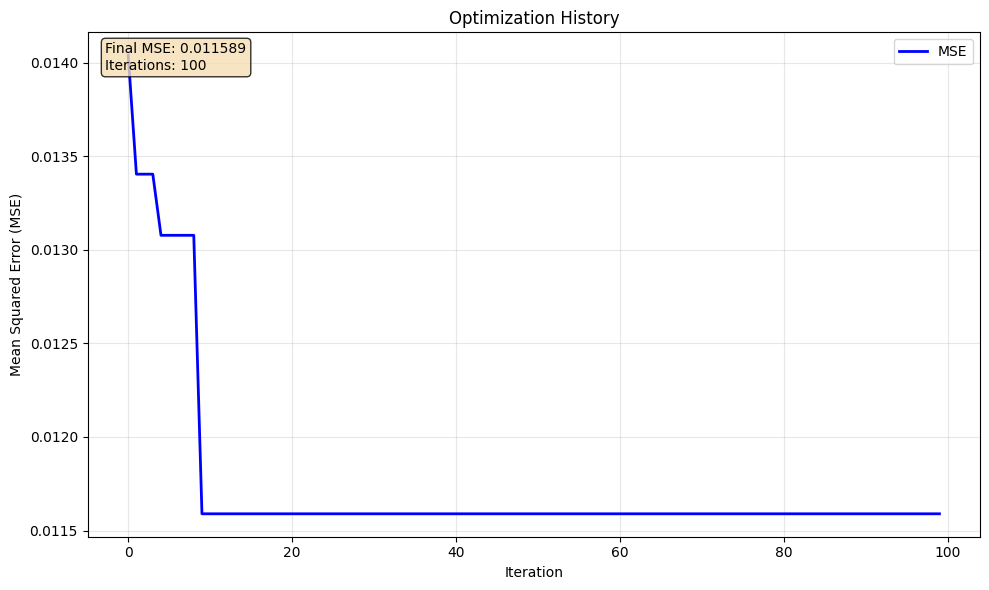

In [10]:
optimizer.plot_optimization_history(result)

In [11]:
optimized_pbn = optimizer.get_optimized_pbn(result)
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data)
BNMPy.vis_network(optimized_pbn,"Bonzanni2013_optimized_CEBPA.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

   Extracted 1 measured nodes: {'SPI1'}
   Extracted 3 perturbed nodes: {'CEBPA', 'GATA1', 'FLI1'}
Network visualization saved to Bonzanni2013_optimized_CEBPA.html


## Simulate the optimized PBN

With the optimized model, we can simulate the steady state of the network.   
  
### HSC differentiation heatmap
One key contribution of the Bonzanni model is to describe the stem-cell heterogeneity through steady state analysis and compare them with expression profiles. Here we perform a similar analysis with the extension of CEBPA to predict the myelopoietic branch.

In [2]:
optimized_pbn = BNMPy.load_pbn_from_string("""
CBFA2T3 = GATA2 & TAL1, 1.0000
CEBPA = CEBPA & !GATA1 & !SMAD3, 1.0000
ERG = ( !CBFA2T3 | !TAL1 ) & ( ERG | FLI1 | GATA2 | RUNX1 ), 1.0000
FLI1 = !GATA1 & ( ERG | FLI1 | GATA2 ), 1.0000
GATA1 = GATA1 & !SPI1 & TAL1, 1.0000
GATA2 = ( ERG | FLI1 | ( GATA2 & TAL1 ) ) & ( !GATA1 | !ZFPM1 ) & ( !GATA2 | !HHEX ), 1.0000
HHEX = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
RUNX1 = ( ERG | FLI1 | RUNX1 | SPI1 | ( GATA2 & TAL1 ) ) & ( !RUNX1 | !SMAD6 ), 1.0000
SMAD3 = SMAD3 & !SMAD6, 1.0000
SMAD6 = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
SPI1 = !GATA1 & !GATA2 & ( CEBPA | RUNX1 | SPI1 ), 0.7654
SPI1 = ( FLI1 | RUNX1 | SPI1 ) & ( !GATA1 | !SPI1 ), 0.2346
TAL1 = ERG | FLI1 | ( GATA1 & TAL1 ) | ( GATA2 & TAL1 ), 1.0000
ZFPM1 = GATA2 & TAL1, 1.0000
""")

No initial state provided, using a random initial state
PBN loaded successfully. There are 13 genes in the network.


In [12]:
def convert_steady_state_to_df(steady_state, node_names):
    all_arrays = []
    row_names = []
    
    if type(steady_state) == dict:
        # Process fixed points
        for i, fp in enumerate(steady_state['fixed_points']):
            all_arrays.append(fp)
            row_names.append(f'S{i+1}')
    
        # Process cyclic attractors
        attractor_counter = len(steady_state['fixed_points']) + 1
        for attractor in steady_state['cyclic_attractors']:
            for j, state in enumerate(attractor):
                all_arrays.append(state)
                row_names.append(f'S{attractor_counter}.{j+1}')
            attractor_counter += 1
    
    else:
        # process single steady state for pbn
        all_arrays.append(steady_state)
        row_names.append(f'S1')

    df = pd.DataFrame(all_arrays)
    df.index = row_names
    df.columns = node_names
    return df

column_order = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1']
column_order_extended = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1','CEBPA']
np.random.seed(9)

# steady state of the original network
steady_state = BNMPy.SteadyStateCalculator(network).compute_steady_state(n_runs=100,n_steps=10000,verbose=False)
df_original = convert_steady_state_to_df(steady_state, network.nodeDict.keys())
df_original.index = df_original.index.str.replace('S', 'O') #using 'O' for stable states from the original model
df_original = df_original[column_order]

# steady state of the optimized network
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
steady_state_pbn = calc.compute_steady_state(method='monte_carlo',p_noise = 0.0, n_steps=10000)
# steady_state_pbn = calc.compute_steady_state(method='tsmc',p_mir = 0.01, freeze_constant=True)
df_pbn = convert_steady_state_to_df(steady_state_pbn, optimized_pbn.nodeDict.keys())
df_pbn.index = df_pbn.index.str.replace('S1', 'Extended_baseline')
df_pbn = df_pbn[column_order_extended]

# steady state of the optimized network with GATA1 stimulated and FLI1 inhibited
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
calc.set_experimental_conditions(stimuli=['GATA1'],inhibitors=['FLI1'])
steady_state_perturbed = calc.compute_steady_state(method='monte_carlo',p_noise = 0.0, n_steps=10000)
# steady_state_perturbed = calc.compute_steady_state(method='tsmc',p_mir = 0.01, freeze_constant=True)
df_perturbed = convert_steady_state_to_df(steady_state_perturbed, optimized_pbn.nodeDict.keys())
df_perturbed.index = df_perturbed.index.str.replace('S1', 'Extended_GATA1=1_FLI1=0')
df_perturbed = df_perturbed[column_order_extended]

# steady state of the optimized network with CEBPA stimulated
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
calc.set_experimental_conditions(stimuli=['CEBPA'])
steady_state_CEBPA = calc.compute_steady_state(method='monte_carlo',p_noise = 0.0, n_steps=10000)
# steady_state_CEBPA = calc.compute_steady_state(method='tsmc',p_mir = 0.01, freeze_constant=True)
df_CEBPA = convert_steady_state_to_df(steady_state_CEBPA, optimized_pbn.nodeDict.keys())
df_CEBPA.index = df_CEBPA.index.str.replace('S1', 'Extended_CEBPA=1')
df_CEBPA = df_CEBPA[column_order_extended]

# # steady state of the optimized network with CEBPA stimulated with 50% efficacy
# calc = BNMPy.SteadyStateCalculator(optimized_pbn)
# calc.set_experimental_conditions(stimuli=['CEBPA'],stimuli_efficacy=[0.5])
# steady_state_CEBPA_50 = calc.compute_steady_state(method='monte_carlo',p_noise = 0.0, n_steps=10000)
# # steady_state_CEBPA_50 = calc.compute_steady_state(method='tsmc',p_mir = 0.01, freeze_constant=True)
# df_CEBPA_50 = convert_steady_state_to_df(steady_state_CEBPA_50, optimized_pbn.nodeDict.keys())
# df_CEBPA_50.index = df_CEBPA_50.index.str.replace('S1', 'Extended_CEBPA=0.5')
# df_CEBPA_50 = df_CEBPA_50[column_order_extended]

In [39]:
df = pd.concat([df_original, df_pbn, df_perturbed, df_CEBPA])
df.to_csv('Bonzanni2013_extended_CEBPA_steady_state.csv')
df

,SMAD6,HHEX,RUNX1,CBFA2T3,ERG,GATA1,GATA2,ZFPM1,TAL1,SPI1,FLI1,CEBPA
O1,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.0,NaN
O2,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,NaN
O3.1,1.000000,1.000000,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.0,NaN
O3.2,1.000000,1.000000,0.00000,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.0,NaN
O4.1,1.000000,1.000000,1.00000,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.0,NaN
O4.2,1.000000,1.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.0,NaN
Extended_baseline,1.000000,1.000000,0.49998,0.500000,0.500000,0.0,0.500000,0.500000,1.0,0.443591,1.0,0.1
Extended_GATA1=1_FLI1=0,0.875005,0.875005,0.44999,0.408358,0.491682,1.0,0.408298,0.408358,1.0,0.356129,0.0,0.2
Extended_CEBPA=1,0.900000,0.900000,0.44997,0.449970,0.449970,0.1,0.450030,0.449970,1.0,0.526835,0.9,1.0


/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_29752/3751344909.py:58: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = matplotlib.patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


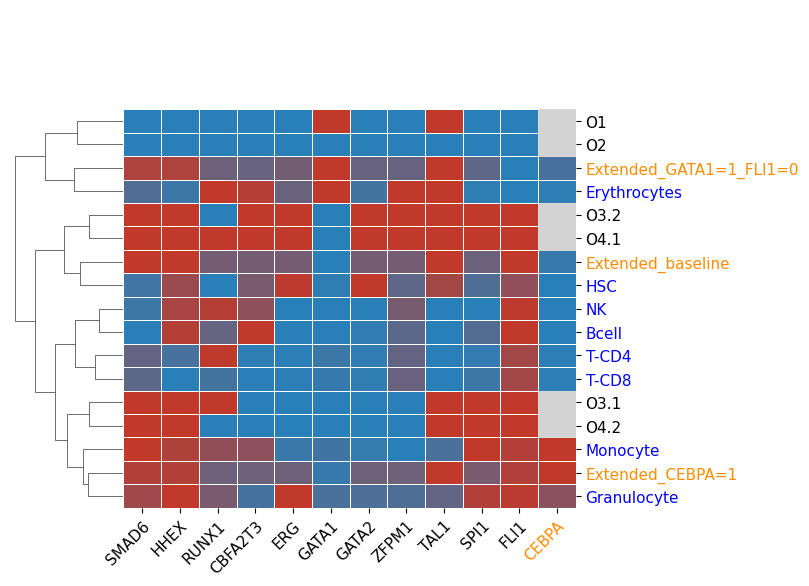

In [47]:
def heatmap(df, figsize=(6, 4), dpi = 300):
    import matplotlib
    import seaborn as sns
    # Create a custom colormap: blue for 0, red for 1
    cmap = matplotlib.colors.ListedColormap(['#2980b9', '#c0392b'])
    bounds = [-0.1, 0.5, 1.1]  # Boundaries to separate colors
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    # Use a continuous colormap from blue (0) to red (1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('blue_red', ['#2980b9', '#c0392b'])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    # Fill NaN values with 0 for clustering
    df_filled = df.fillna(0)
    
    # Mask NaN values for clustering
    mask = df.isna()

    # Create the clustermap
    g = sns.clustermap(df_filled, method='complete', metric='seuclidean', cmap=cmap, norm=norm,
                       linewidths=0.5, linecolor='white', figsize=figsize, cbar=False, col_cluster=False)
    g.ax_heatmap.tick_params(axis='y', labelsize=11)
    g.ax_heatmap.tick_params(axis='x', labelsize=11)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels
    g.cax.set_visible(False)

    # Determine the color based on the label text
    def get_ylabel_color(label):
        if label.startswith('O'):
            return 'black'
        elif label.startswith('Extended'):
            return 'darkorange'
        else:
            return 'blue'
    
    def get_xlabel_color(label):
        if label.upper() in {x.upper() for x in column_order_extended} - {x.upper() for x in column_order}:
            return 'darkorange'
        else:
            return 'black'
            
    # Set the color of labels based on their text
    for label in g.ax_heatmap.get_yticklabels():
        label.set_color(get_ylabel_color(label.get_text()))
    for label in g.ax_heatmap.get_xticklabels():
        label.set_color(get_xlabel_color(label.get_text()))

    # Add grey patches on NA grid cells based on clustered positions
    for (i, j), val in np.ndenumerate(df.values):
        if pd.isna(val):
            # Get the correct row and column indices in the clustered heatmap
            row_index = df.index[i]
            col_index = df.columns[j]
            # Find the positions in the clustered heatmap
            row_pos = np.where(g.data2d.index == row_index)[0][0]
            col_pos = np.where(g.data2d.columns == col_index)[0][0]
            # Create a rectangle patch with light grey fill
            rect = matplotlib.patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)
            g.ax_heatmap.add_patch(rect)

    plt.show()

df_csv = pd.read_csv('/Users/luna/Desktop/GRN_Modeling/LogicModelMerger/Data/Expression/Chambers2007_filtered_CEBPA.csv')
df_csv = df_csv.groupby('Gene', as_index=False).mean()
df_csv.set_index('Gene', inplace=True)
#  Gene-wise 0-1 normalisation
#    (value - min) / (max - min)   for each row independently
norm = df_csv.sub(df_csv.min(axis=1), axis=0) \
           .div(df_csv.max(axis=1) - df_csv.min(axis=1), axis=0)
df_csv = norm.T

column_order_extended = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1','CEBPA']
df_csv = df_csv[column_order_extended]
df_merged = pd.concat([df, df_csv])
heatmap(df_merged, (8,6), dpi=300)

- Erythroid: the canonical erythroid push (GATA1 = 1, FLI1 = 0) aligns with Bonzanni's O1 state and erythrocytes profile, showing the shortcut is silent when GATA factors are high.

- HSC: the baseline extended attractor cluster with Bonzanni’s cyclic attractors and HSCs.

- Myeloid: Extended_CEBPA = 1 cluster with granulocyte/monocyte profiles, with PU.1, RUNX1, FLI1 ON and GATA1 OFF as CEBPA-driven myelopoiesis (PMID: 29847803)

- Lymphoid: B, T and NK signatures remain separate.

Together, we recover the stem-cell heterogeneity described by Bonzanni, generate an additional PU.1-high myeloid attractor that clusters with granulocytes/monocytes, and retain the erythroid attractor. This extension therefore reproduces the lineage spectrum seen in health and provides a quantitative handle for modelling CEBPA-mutant AML.  


### Model AML with CEBPA p30 mutation
CEBPA encodes the 42-kDa transcription factor C/EBPα-p42, N-terminal frame-shift mutations truncate p42 and force translation of a 30-kDa isoform (“p30”) that lacks the trans-activation domain yet retains DNA binding, thereby competing with p42 and blocking normal C/EBPα function, leading to 50 – 80 % loss of C/EBPα function (PMID: 20884804).  

Therefore, we lower the probability of CEBPA-driven rule to 50% of the optimized value of HSC to model these patients with CEBPA p30 mutation. 
  
Previous studies have shown that C/EBPα dose controls PU.1 enhancer activity (PMID: 17671233), we therefore want to model this effect by increasing CEBPA stimulus efficacy.


In [43]:
# CEBPA-mutant AML have 50% loss of function
p = 0.7781/2
pbn_aml_string = f"""
CBFA2T3 = GATA2 & TAL1, 1.0000
CEBPA = CEBPA & !GATA1 & !SMAD3, 1.0000
ERG = ( !CBFA2T3 | !TAL1 ) & ( ERG | FLI1 | GATA2 | RUNX1 ), 1.0000
FLI1 = !GATA1 & ( ERG | FLI1 | GATA2 ), 1.0000
GATA1 = GATA1 & !SPI1 & TAL1, 1.0000
GATA2 = ( ERG | FLI1 | ( GATA2 & TAL1 ) ) & ( !GATA1 | !ZFPM1 ) & ( !GATA2 | !HHEX ), 1.0000
HHEX = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
RUNX1 = ( ERG | FLI1 | RUNX1 | SPI1 | ( GATA2 & TAL1 ) ) & ( !RUNX1 | !SMAD6 ), 1.0000
SMAD3 = SMAD3 & !SMAD6, 1.0000
SMAD6 = ERG | FLI1 | ( GATA2 & TAL1 ), 1.0000
SPI1 = !GATA1 & !GATA2 & ( CEBPA | RUNX1 | SPI1 ), {p}
SPI1 = ( FLI1 | RUNX1 | SPI1 ) & ( !GATA1 | !SPI1 ), {1-p}
TAL1 = ERG | FLI1 | ( GATA1 & TAL1 ) | ( GATA2 & TAL1 ), 1.0000
ZFPM1 = GATA2 & TAL1, 1.0000
"""
pbn_aml = BNMPy.load_pbn_from_string(pbn_aml_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 13 genes in the network.


In [ ]:
spi1 = []
spi1_runx1 = []
spi1_aml = []
spi1_aml_runx1 = []

# WT
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
steady_state_WT = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
spi1_baseline = steady_state_WT[optimized_pbn.nodeDict['SPI1']]

# AML
calc = BNMPy.SteadyStateCalculator(pbn_aml)
steady_state_AML = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
spi1_aml_baseline = steady_state_AML[optimized_pbn.nodeDict['SPI1']]

cebp_efficacies = np.linspace(0, 0.999, 20)
for eff in cebp_efficacies:
    # WT with CEBPA stimulation
    calc = BNMPy.SteadyStateCalculator(optimized_pbn)
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff])
    steady_state_CEBPA = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
    spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
    spi1.append(spi1_val)

    # WT with CEBPA stimulation and RUNX1 inhibition
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff], inhibitors=['RUNX1'])
    steady_state_CEBPA = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
    spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
    spi1_runx1.append(spi1_val)

    # AML with CEBPA stimulation
    calc = BNMPy.SteadyStateCalculator(pbn_aml)
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff])
    steady_state_CEBPA = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
    spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
    spi1_aml.append(spi1_val)

    # AML with CEBPA stimulation and RUNX1 inhibition
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff], inhibitors=['RUNX1'])
    steady_state_CEBPA = calc.compute_steady_state(method='monte_carlo', p_noise=0.05, n_runs=10, n_steps=10000, seed=9)
    spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
    spi1_aml_runx1.append(spi1_val)

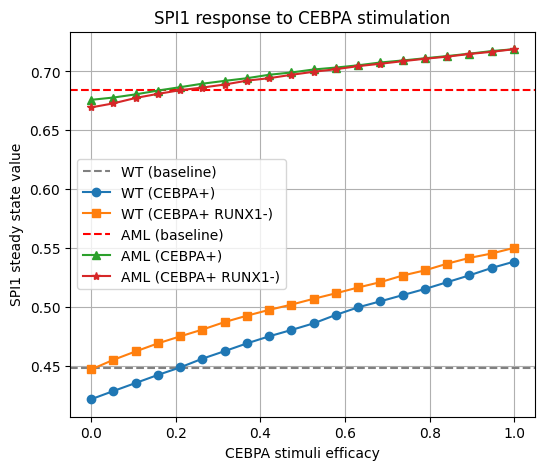

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.axhline(y=spi1_baseline, color='grey', linestyle='--', label='WT (baseline)')
plt.plot(cebp_efficacies, spi1, marker='o', label='WT (CEBPA+)')
plt.plot(cebp_efficacies, spi1_runx1, marker='s', label='WT (CEBPA+ RUNX1-)')

plt.axhline(y=spi1_aml_baseline, color='red', linestyle='--', label='AML (baseline)')
plt.plot(cebp_efficacies, spi1_aml, marker='^', label='AML (CEBPA+)')
plt.plot(cebp_efficacies, spi1_aml_runx1, marker='*', label='AML (CEBPA+ RUNX1-)')
plt.xlabel('CEBPA stimuli efficacy')
plt.ylabel('SPI1 steady state value')
plt.title('SPI1 response to CEBPA stimulation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# fraction of high PU1
repeats = 1000
cebp_efficacies = np.linspace(0, 0.999, 20)
threshold = 0.65
spi1_high_frac = []
spi1_runx1_high_frac = []
for eff in cebp_efficacies:
    # CEBPA only
    calc = BNMPy.SteadyStateCalculator(optimized_pbn)
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff])
    spi1_final_vals = []
    for rep in range(repeats):
        steady_state_CEBPA = calc.compute_steady_state(
            method='monte_carlo', p_noise=0.05, n_runs=1, n_steps=10000, seed=rep
        )
        spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
        spi1_final_vals.append(spi1_val)
    high_frac = np.mean(np.array(spi1_final_vals) > threshold)
    spi1_high_frac.append(high_frac)

    # CEBPA + RUNX1 inhibitor
    calc.set_experimental_conditions(stimuli=['CEBPA'], stimuli_efficacy=[eff], inhibitors=['RUNX1'])
    spi1_final_vals_runx1 = []
    for rep in range(repeats):
        steady_state_CEBPA = calc.compute_steady_state(
            method='monte_carlo', p_noise=0.05, n_runs=1, n_steps=10000, seed=1000 + rep
        )
        spi1_val = steady_state_CEBPA[optimized_pbn.nodeDict['SPI1']]
        spi1_final_vals_runx1.append(spi1_val)
    high_frac_runx1 = np.mean(np.array(spi1_final_vals_runx1) > threshold)
    spi1_runx1_high_frac.append(high_frac_runx1)

# Steady state test

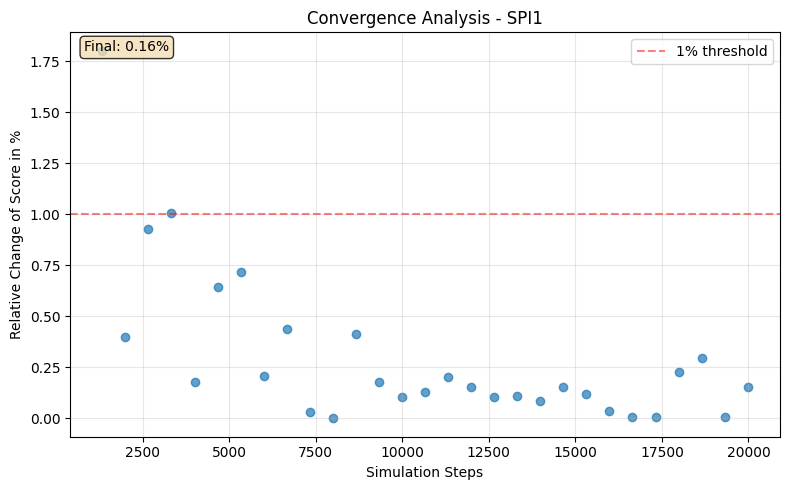

array([0.44125587, 0.24167583, 0.52224778, 0.79042096, 0.13648635,
       0.45285471, 0.86281372, 0.49685031, 0.06189381, 0.86121388,
       0.45925407, 0.9120088 , 0.44015598])

In [37]:
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
steady_state,_ = calc.compute_steady_state(method='monte_carlo',n_runs=10,n_steps=20000,p_noise=0.05, seed = 9, analyze_convergence=True, output_node='SPI1')
steady_state

In [130]:
calc.compute_steady_state(method='tsmc',p_mir=0.05)

array([0.51479302, 0.60489658, 0.02138431, 0.47992036, 0.959732  ,
       0.47545595, 0.93939415, 0.49654127, 0.4758161 , 0.48891033,
       0.95143513, 0.95124487])

In [3]:
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
calc.set_experimental_conditions(stimuli=['GATA1'],inhibitors=['FLI1'])
calc.compute_steady_state(method='monte_carlo',p_noise=0.0,n_steps=10000, n_runs=10)

array([0.40839832, 0.1       , 0.59172166, 0.        , 1.        ,
       0.40827834, 0.975005  , 0.49998   , 0.        , 0.975005  ,
       0.29540092, 1.        , 0.40839832])

In [12]:
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
calc.set_experimental_conditions(stimuli=['GATA1'],inhibitors=['FLI1'])
calc.compute_steady_state(method='tsmc',p_mir=0.05,freeze_constant=True)

array([0.22633997, 0.05298622, 0.45053599, 0.        , 1.        ,
       0.20612557, 0.48667688, 0.38223583, 0.10842266, 0.48973966,
       0.11883614, 0.88024502, 0.22480858])

In [61]:
optimized_pbn.nodeDict

{'CBFA2T3': 0,
 'CEBPA': 1,
 'ERG': 2,
 'FLI1': 3,
 'GATA1': 4,
 'GATA2': 5,
 'HHEX': 6,
 'RUNX1': 7,
 'SMAD3': 8,
 'SMAD6': 9,
 'SPI1': 10,
 'TAL1': 11,
 'ZFPM1': 12}

# Experimental data
## Ramos data

In [7]:
import pandas as pd
exp = pd.read_csv("/Users/luna/Downloads/LogicModelMerger/Data/Expression/Expression_Ramos.csv")
exp

,Gene,Expression
0,CBFA2T3,0.166667
1,FLI1,0.416667
2,GATA1,0.000000
3,GATA2,0.333333
4,HHEX,0.416667
5,SPI1,0.333333
6,RUNX1,0.083333
7,TAL1,0.500000
8,SMAD6,0.416667
9,ZFPM1,0.166667


## Chambers data

In [41]:
# Load the CSV file 
df_csv = pd.read_csv('/Users/luna/Desktop/GRN_Modeling/LogicModelMerger/Data/Expression/Chambers2007.csv')
df_csv['Gene'] = df_csv['Gene'].str.upper()

# filter genes in network
genes = list(network.nodeDict.keys()) + ['SFPI1','CBFA2T3H','CEBPA'] # Pu.1 + Eto2 + Cebpa
df_csv = df_csv[df_csv['Gene'].isin(genes)]

df_csv.sort_values(by='Gene', inplace=True)
df_csv['Gene'] = df_csv['Gene'].str.replace('CBFA2T3H', 'CBFA2T3')
df_csv['Gene'] = df_csv['Gene'].str.replace('SFPI1', 'SPI1')
df_csv.set_index('Gene', inplace=True)
df_csv.to_csv('/Users/luna/Desktop/GRN_Modeling/LogicModelMerger/Data/Expression/Chambers2007_filtered_CEBPA.csv')
df_csv

,HSC,NK,T-CD4,T-CD8,Bcell,Monocyte,Granulocyte,Erythrocytes
Gene,,,,,,,,
CBFA2T3,0.371486,0.395701,0.229254,0.215733,0.440677,0.384741,0.270129,0.464084
CBFA2T3,0.348450,0.368211,0.333731,0.335231,0.429677,0.380128,0.340049,0.381486
CEBPA,0.116633,0.117453,0.118507,0.118316,0.117157,0.191828,0.165223,0.119727
ERG,0.725453,0.163177,0.173433,0.173305,0.165626,0.220643,0.731927,0.401119
ERG,0.140435,0.141659,0.143582,0.145206,0.143324,0.148496,0.146827,0.145276
FLI1,0.743884,0.828764,0.767761,0.792327,0.840323,0.782677,0.793858,0.584398
FLI1,0.505206,0.603100,0.551045,0.536536,0.607784,0.598416,0.625356,0.249867
FLI1,0.136863,0.139272,0.143881,0.139530,0.138270,0.149978,0.141639,0.139631
GATA1,0.143385,0.120446,0.186567,0.166389,0.122511,0.204421,0.244171,0.670817


In [33]:
# Group by Gene and calculate the mean for each gene to handle duplicates
df_csv_grouped = df_csv.groupby('Gene', as_index=True).mean()
df_csv_grouped

,HSC,NK,T-CD4,T-CD8,Bcell,Monocyte,Granulocyte,Erythrocytes
Gene,,,,,,,,
CBFA2T3,0.359968,0.381956,0.281493,0.275482,0.435177,0.382435,0.305089,0.422785
ERG,0.432944,0.152418,0.158507,0.159255,0.154475,0.184570,0.439377,0.273198
FLI1,0.461984,0.523712,0.487562,0.489464,0.528792,0.510357,0.520284,0.324632
GATA1,0.143385,0.120446,0.186567,0.166389,0.122511,0.204421,0.244171,0.670817
GATA2,0.431791,0.144205,0.159701,0.158502,0.159529,0.165801,0.212321,0.193866
HHEX,0.651008,0.692776,0.400299,0.307360,0.730297,0.715274,0.767543,0.366654
JUN,0.605636,0.302033,0.460896,0.419157,0.322031,0.572448,0.339021,0.269313
RUNX1,0.181480,0.194915,0.195712,0.184022,0.187252,0.191599,0.189126,0.195970
SMAD6,0.112764,0.112671,0.113731,0.113535,0.112102,0.116309,0.115386,0.113191


## 	Lara-Astiaso data

In [14]:
df = pd.read_csv("/Users/luna/Desktop/GRN_Modeling/LogicModelMerger/Data/Expression/LaraAstiaso2014.txt", sep="\t")
df['NAME'] = df['NAME'].str.strip().str.upper()
genes = list(network.nodeDict.keys()) + ['SFPI1','CBFA2T3H','CSF3R','CEBPA','JUN'] # Pu.1 + Eto2 + Csf3r
expr = df[df['NAME'].isin(genes)].drop(columns=['UNIQUD']).set_index('NAME')
expr = expr.apply(pd.to_numeric, errors='coerce').sort_index().groupby('NAME').mean()
expr

,LT-HSC,HSC,MPP,CLP,CMP,GMP,MF,Granulocyte,Mono,B,CD4,CD8,NK,MEP,EryA,EryB
NAME,,,,,,,,,,,,,,,,
CBFA2T3,3106.369,5806.728033,898.835367,1199.932433,1124.523967,646.670733,455.997333,558.825233,932.569867,1366.549567,35.73760,41.57750,1596.155533,2036.834967,810.29950,544.339667
CEBPA,19.294,47.027300,135.082400,52.266100,411.705500,493.991900,66.727300,30.023600,152.784700,2.789300,10.58720,4.15710,34.113600,25.733500,6.02800,0.948000
CSF3R,202.589,161.033600,191.606800,45.818700,205.334500,273.014900,194.972700,589.693900,329.097700,0.000000,1.32390,6.65270,268.632700,24.116000,20.08970,8.530000
ERG,974.358,474.552600,198.418700,279.832900,256.669300,144.382100,39.170300,25.300500,7.391600,5.576400,0.00000,2.49420,17.052600,45.835000,2.51160,2.843000
FLI1,1032.241,1299.668100,210.541500,322.592000,464.789800,421.063400,94.473900,172.295800,146.071200,2632.630600,750.51640,755.87170,1726.893200,145.534100,37.66380,17.060000
GATA1,501.650,827.966800,15.228200,156.081300,141.771200,39.209300,127.212400,3.272900,21.277500,2.788100,22.50400,9.97740,4.264800,2078.606600,2115.41730,888.067000
GATA2,1119.065,2304.357400,124.957500,33.337100,567.081600,315.894100,122.154000,2.392400,9.408600,0.000000,0.00000,0.83180,8.529800,845.906400,4.51950,3.791000
HHEX,318.355,342.018900,215.860900,280.579900,305.543400,216.213500,85.283100,82.228700,118.064700,527.097300,14.56140,4.98830,302.737700,247.586100,12.55670,7.582000
JUN,694.592,738.192700,132.832400,548.828400,214.072000,172.604200,140.711900,219.229400,170.227500,108.757800,38.38380,24.11650,98.060600,76.385200,12.55720,8.530000


In [15]:
#  Gene-wise 0-1 normalisation
#    (value - min) / (max - min)   for each row independently
norm = expr.sub(expr.min(axis=1), axis=0) \
           .div(expr.max(axis=1) - expr.min(axis=1), axis=0)

norm

,LT-HSC,HSC,MPP,CLP,CMP,GMP,MF,Granulocyte,Mono,B,CD4,CD8,NK,MEP,EryA,EryB
NAME,,,,,,,,,,,,,,,,
CBFA2T3,0.532080,1.000000,0.149558,0.201732,0.188665,0.105863,0.072823,0.090641,0.155404,0.230604,0.000000,0.001012,0.270390,0.346751,0.134216,0.088131
CEBPA,0.037210,0.093459,0.272054,0.104084,0.833105,1.000000,0.133415,0.058972,0.307958,0.003735,0.019550,0.006509,0.067267,0.050270,0.010303,0.000000
CSF3R,0.343549,0.273080,0.324926,0.077699,0.348205,0.462977,0.330634,1.000000,0.558082,0.000000,0.002245,0.011282,0.455546,0.040896,0.034068,0.014465
ERG,1.000000,0.487041,0.203640,0.287197,0.263424,0.148182,0.040201,0.025966,0.007586,0.005723,0.000000,0.002560,0.017501,0.047041,0.002578,0.002918
FLI1,0.388130,0.490374,0.073973,0.116813,0.171179,0.154461,0.029597,0.059351,0.049324,1.000000,0.280419,0.282467,0.653713,0.049119,0.007877,0.000000
GATA1,0.236133,0.390593,0.005888,0.072560,0.065787,0.017240,0.058895,0.000229,0.008752,0.000000,0.009332,0.003403,0.000699,0.982576,1.000000,0.419041
GATA2,0.485630,1.000000,0.054227,0.014467,0.246091,0.137086,0.053010,0.001038,0.004083,0.000000,0.000000,0.000361,0.003702,0.367090,0.001961,0.001645
HHEX,0.600194,0.645518,0.403886,0.527843,0.575656,0.404561,0.153789,0.147939,0.216576,1.000000,0.018335,0.000000,0.570282,0.464650,0.014496,0.004968
JUN,0.940245,1.000000,0.170356,0.740477,0.281695,0.224863,0.181155,0.288763,0.221606,0.137362,0.040915,0.021361,0.122701,0.092995,0.005519,0.000000
